In [1]:
import os
import shutil
import requests
import api_keys
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup


In [23]:
# Defining the support functions 

def file_fetch(url, target_folder, year_start):

    '''This function have as inputs an url, the name of the target folder that all the files will be stored and the year_start. All inputs are strings.'''
    
    # URL to be fetched from 
    url_fetch = url
    response = requests.get(url)

    # Parsing the HTML content
    soup = BeautifulSoup(response.content, 'html.parser')

    # Finding the section with the 'Archived Files (zip format)' title
    section = soup.find('th', string = 'Archived Files (zip format)')

    # Selecting the parent table and rows within it
    parent_table = section.find_parent('table')
    rows = parent_table.find_all('tr')

    # Initializing a list to store the file URLs
    file_urls = []

    # Iterating through the rows to find the CSV file URLs
    for row in rows:
        # Getting the cells in each row
        cells = row.find_all('td')

        # Checking if the cells contain the CSV file URLs
        if cells and cells[0].find('a') and cells[0].find('a').get('href').endswith('.zip'):
            year = cells[0].find('a').text[-4:]
            if int(year) >= int(year_start):
                file_url = url.rsplit('/', 1)[0] + '/' + cells[0].find('a').get('href')
                file_urls.append(file_url)

    # Creating the target folder if it doesn't exist
    if not os.path.exists(target_folder):
        os.makedirs(target_folder)

    # Downloading the files to the target folder
    for file_url in file_urls:
        file_name = file_url.split('/')[-1]
        file_path = os.path.join(target_folder, file_name)
        if not os.path.exists(file_path):
            print(f'Downloading {file_name}...')
            with open(file_path, 'wb') as f:
                response = requests.get(file_url)
                f.write(response.content)
        else:
            print(f'{file_name} already exists, skipping...')

def file_mgmt(main_folder):

    '''This function will inspect the folder (passed as input) and will move the files to its outer level.'''

    # Iterate through all subfolders in main folder
    for subfolder in os.listdir(main_folder):
        subfolder_path = os.path.join(main_folder, subfolder)
        
        # Check if subfolder is a directory
        if os.path.isdir(subfolder_path):
            
            # Iterate through all files in subfolder
            for file_name in os.listdir(subfolder_path):
                file_path = os.path.join(subfolder_path, file_name)
                # Move file to main folder
                shutil.move(file_path, main_folder)
            
def merge_csv(folder_path):
    
    '''Merge multiple CSV files in a given folder into a single Dataframe.'''
    
    # Get all files in the folder
    files = os.listdir(folder_path) 

    # Filter for only CSV files
    csv_files = [f for f in files if f.endswith('.csv')] 
    csv_files = sorted(csv_files)
    dfs = []
    for file in csv_files:
        file_path = os.path.join(folder_path, file) 
        df = pd.read_csv(file_path) 
        dfs.append(df)
    merged_df = pd.concat(dfs, ignore_index=True)
    return merged_df

def noaa_call(start_year, end_year):

    '''This function will make a call using an API key into NOAA to retrieve Wet Bulb, Dry Bulb, Max and Min Temperature
    over the 2018-2020 horizon for NYC, LGA and JFK. The inputs are start_year and end_year in %Y format'''

    url = "https://www.ncdc.noaa.gov/cdo-web/api/v2/data"

    # Set the request headers with your API key
    headers = {"token": api_keys.api_key}

    # Set the query parameters template
    params_template = {
        "datasetid": "GHCND",
        "datatypeid": ["TAVG", "TMAX", "TMIN"],
        "stationid": ["GHCND:USW00094728", "GHCND:USW00094789", "GHCND:USW00094789"],
        "units": "standard",
        "limit": "1000",
        "offset": "0",
    }

    # Initialize an empty DataFrame to store the response data
    data = pd.DataFrame()

    # Loop through the years of interest
    for year in range(start_year, end_year + 1):

        # Set the start and end dates for the current year
        start_date = f"{year}-01-01"
        end_date = f"{year}-12-31"

        # Update the query parameters with the current year's dates
        params = params_template.copy()
        params["startdate"] = start_date
        params["enddate"] = end_date

        # Make the request and store the response
        response = requests.get(url, headers = headers, params = params)

        # Parse the response content into a DataFrame
        year_data = pd.json_normalize(response.json()['results'])

        # Set the timestamp as the index of the DataFrame
        year_data["date"] = pd.to_datetime(year_data["date"])
        year_data = year_data.set_index("date")

        # Extract the wet bulb, dry bulb, and temperature columns for each station
        nyc_data = year_data.loc[year_data["station"] == "GHCND:USW00094728", ["datatype", "value"]]
        lga_data = year_data.loc[year_data["station"] == "GHCND:USW00094789", ["datatype", "value"]]
        jfk_data = year_data.loc[year_data["station"] == "GHCND:USW00094789", ["datatype", "value"]]

        # Pivot the data to put the datatypes into columns
        nyc_data = nyc_data.pivot(columns = "datatype", values = "value")
        lga_data = lga_data.pivot(columns = "datatype", values = "value")
        jfk_data = jfk_data.pivot(columns = "datatype", values = "value")

        # Combine the data for all three stations into a single DataFrame for the current year
        year_data = pd.concat([nyc_data, lga_data, jfk_data], axis = 1, keys = ["NYC", "LGA", "JFK"])

        # Append the current year's data to the overall DataFrame
        data = data.append(year_data)

    # Return the resulting DataFrame
    return data


In [3]:
# Data URLs from the NYISO website
# rt_data = 'http://mis.nyiso.com/public/P-58Blist.htm'
# weather_data = 'http://mis.nyiso.com/public/P-7Alist.htm'

# Running our function to fetch the data from the NYISO URLs listed
# rt_fetch = file_fetch(rt_data, 'rt_files', '2017')
# weather_fetch = file_fetch(weather_data, 'weather_files', '2017')

### Unzipped files management
After the files are manually unzipped, I run a script to move them to an upper folder level before we start merging those DataFrames. You can find the code below. It is possible to unzip the files automatically and move them - but for the sake of simplificity I manually did it and inspected the file integrity. You're invited to change the instruction at your own will.

In [4]:

# Moving files from one folder to their upper level
# file_mgmt('rt_files')
# file_mgmt('weather_files')


### Merging Real-Time (RT) data and Weather daily files
The next step is to merge all the Real-Time and Weather daily files into a database each. Then, those will be merged into one big dataset so we can use for our time series analysis procedure. If you are running this script, please note that I manually deleted the folders that had the files inside. So you'll might need to run some adjustments outside of the code below before running it (depending on the file structure you have been using so far).

In [5]:
# Merging the Real-Time and Weather files
df_rt = merge_csv('rt_files')
df_wx = merge_csv('weather_files')

# Formatting TimeStamp
df_rt['Time Stamp'] = pd.to_datetime(df_rt['Time Stamp'], format = '%m/%d/%Y %H:%M:%S')

# Forecast and Vintage Date formatting
df_wx['Forecast Date'] = pd.to_datetime(df_wx['Forecast Date'], format = '%m/%d/%Y')
df_wx['Vintage Date'] = pd.to_datetime(df_wx['Vintage Date'], format = '%m/%d/%Y')


### Graphical analysis
I plot then the Hourly Load per Zone, within the NYISO area. We can note there's an issue with the data from Apr/2017. Unfortunately, the file that is made available on the NYISO website only lists 6 days (25th-30th). We can also spot check that the same month in 2021 has missing data, which is an issue that we cannot circumvent without eliminating those data points.

Nonetheless, through an overall inspection we can see that NYC is the region with most load flowing through the system, followed by Long Island and the Capital regions. For the sake of time constraints, I will focus only in the NYC area (Zone J). If you want to know more, each location is bucketed into zones and these can be found <a href = 'https://www.nyiso.com/documents/20142/1397960/nyca_zonemaps.pdf/8c3807e1-5bab-ab44-3c71-2c8e61b5748b' alt = 'NYISO New York Control Area Zone Maps'>here</a>.  

On an overall inspection, we can see that winter time has more load than the rest of the year, followed by summertime. For the forecasting exercise I'll limit the sample from January 2018 to December 2020 - so we avoid any missing data from our estimates.

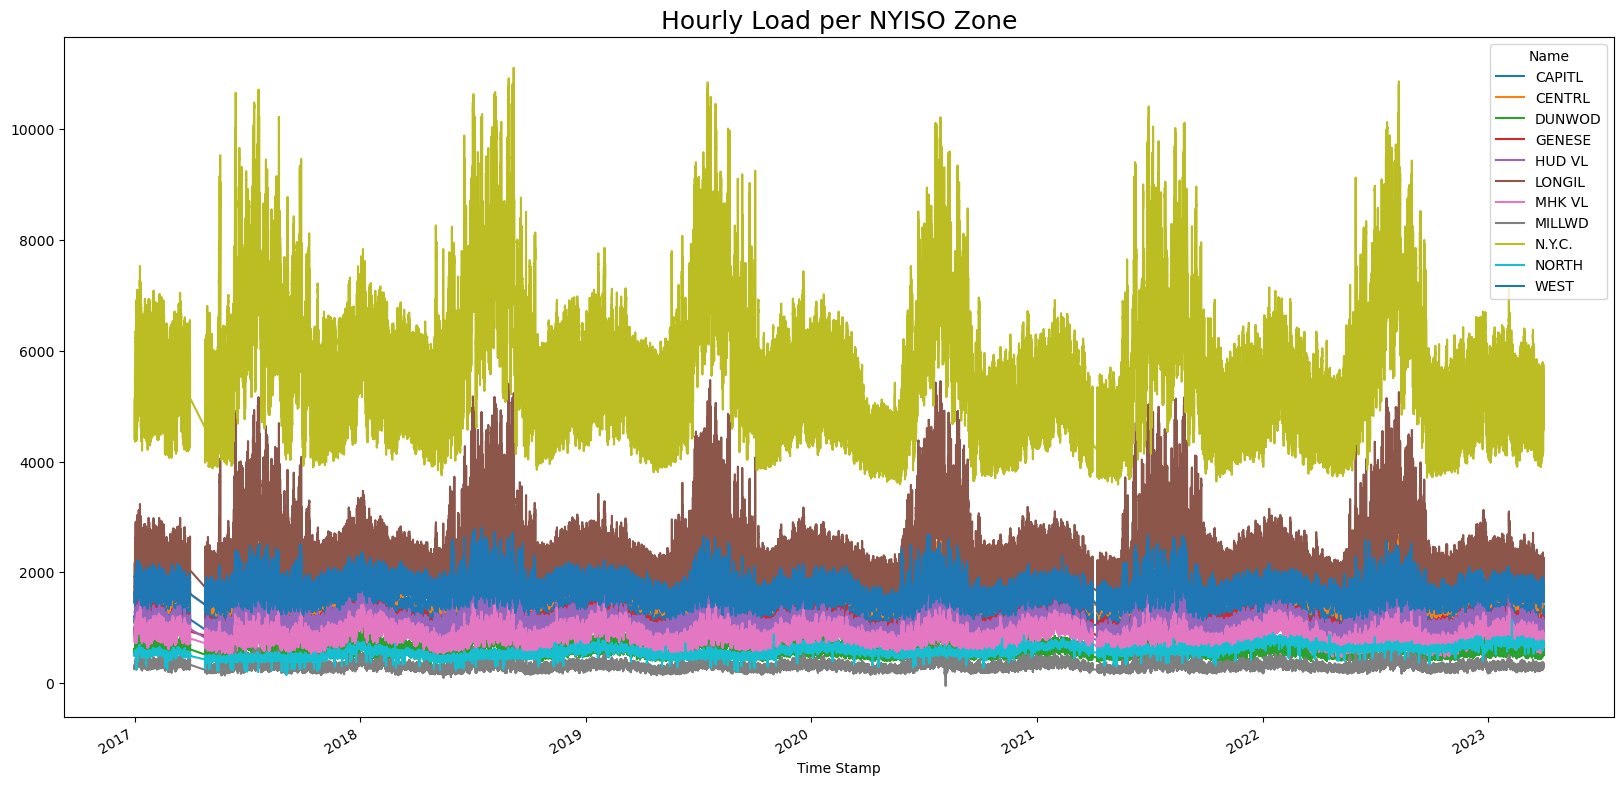

In [6]:
# Generating a Pivot Table to plot the Graph
table = pd.pivot_table(df_rt, values = 'Load', index = ['Time Stamp'], columns = ['Name'])

# Configuring and Plotting the table
fig, ax = plt.subplots(figsize = (20, 10))
table.plot(ax = ax)
ax.set_title('Hourly Load per NYISO Zone', fontsize = 18)
ax.set_xlabel('Time Stamp')
plt.show();

# Filtering the dataset for NYC and just the time horizon we're sure doesn't have any missing data
df = df_rt[(df_rt['Time Stamp'] >= '01/01/2018') & (df_rt['Time Stamp'] <= '12/31/2020') & (df_rt['Name'] == 'N.Y.C.')]


### Working with weather data
Now, I'll start working with weather data. We have several locations that are identified as Station IDs. For the New York City, the process os evaluating the weather station is a weighted average between the IDs (in parenthesis) pertaining to Central Park (NYC), LaGuardia (LGA) and the JFK Airports (JFK). The process of generating the Climate Temperature and Humidity Index (CTHI) can be found <a href='https://www.nyiso.com/documents/20142/20053386/LFU_Whitepaper_Phase1_Results.pdf/40ce5384-d790-b3f5-cc55-270b39ab23fe' alt = 'NYISO Climate Temperature and Humidity Index (CTHI) methodology'>here</a>.

Due to data availability issues, I calculate a proxy for this measurement. Also, since I don't have temperature data available at the hourly frequency - these estimates are less precise than the ideal ones. I use a simple resample procedure so we can have the 24 hour time, however this is far from perfect. Lastly, we can then merge both DataFrames with respect to their dates so we can start working on the load estimates.

In [7]:
# Now creating a new DataFrame, we filter for JFK, LGA and NYC
df2 = df_wx[(df_wx['Station ID'] == 'JFK') | (df_wx['Station ID'] == 'LGA') | (df_wx['Station ID'] == 'NYC')]

# Formatting to datetime
df2['Forecast Date'] = pd.to_datetime(df2['Forecast Date'], format = '%m/%d/%Y')
df2['Vintage Date'] = pd.to_datetime(df2['Vintage Date'], format = '%m/%d/%Y')

# Next, filtering for the same time frame as the RT dataframe
df2 = df2[(df2['Forecast Date'] >= '01/01/2018') & (df2['Vintage Date'] <= '12/31/2020')]

# Creating a proxy weighted average THI
df2['THI'] = 0.8 * df2['Max Wet Bulb'] + 0.2 * df2['Min Wet Bulb']

# Groupby Vintage Date and filtering columns
df_weather = df2.groupby(pd.Grouper(key = 'Vintage Date', freq = 'D')).max()
df_weather = df_weather.loc[:, ['Forecast Date', 'THI']]

# Creating a proxy CTHI
df_weather['CTHI'] = 0.7 * df_weather['THI'] + 0.2 * df_weather['THI'][1] + 0.1 * df_weather['THI'][2]


/var/folders/b0/v978w3bs7jq5j7qgfd2wjxtw0000gn/T/ipykernel_4561/3790054175.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Forecast Date'] = pd.to_datetime(df2['Forecast Date'], format = '%m/%d/%Y')
/var/folders/b0/v978w3bs7jq5j7qgfd2wjxtw0000gn/T/ipykernel_4561/3790054175.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Vintage Date'] = pd.to_datetime(df2['Vintage Date'], format = '%m/%d/%Y')


In [8]:
# Merging the two datasets (real-time and weather), filtering and filling NAs
df_weather.reset_index(inplace = True)
df_weather.rename({'Vintage Date': 'Time Stamp'}, axis = 1 , inplace = True)
data = pd.merge(df, df_weather, on = 'Time Stamp', how = 'left') 
data = data.loc[:,['Time Stamp', 'Load', 'CTHI']]
data = data.fillna(method = 'ffill')


### Working with the NOAA API Call
I start calling data from National Oceanic and Atmospheric Administration (NOAA) using an API. This will allow me to have more granular data (at the hourly level), so we can have the maximum and minimum temperature at the locations (New York City, Central Park; LaGuardia Airport and JFK Airport) that are relevant to the NYC NYISO Zone J.

From this dataset, I calculate then the cooling day degree (CDD) and the heating day degree (HDD). These are well established statistics that try to capture load dynamics with respect to a baseline level of 65 degrees. This statistic is far from perfect, since it misses to capture non-linear relationships, however it is an increment to the CTHI one we calculated above.

In [24]:
# Calling the NOAA API
noaa = noaa_call(2018, 2020)

# Splitting per area: NYC, LGA and JFK
nyc_data = noaa['NYC'].reset_index()
lga_data = noaa['LGA'].reset_index()
jfk_data = noaa['JFK'].reset_index()

# Temperature Calculation - CDD and HDD
loc_list = [
    'nyc_data',
    'lga_data',
    'jfk_data'
]

# Creating Cooling Degree Days and Heating Degree Days columns CDD/HDD
for name in loc_list:
    globals()[name]['CDD'] = (globals()[name]['TMAX'] + globals()[name]['TMIN']) / 2 - 65
    globals()[name]['HDD'] = 65 - (globals()[name]['TMAX'] + globals()[name]['TMIN']) / 2
    
    # Max value CDD/HDD or 0
    globals()[name].loc[globals()[name]['CDD'] < 0, 'CDD'] = 0
    globals()[name].loc[globals()[name]['HDD'] < 0, 'HDD'] = 0

KeyError: 'results'

In [ ]:
# Filtering the fields we want
nyc_data = nyc_data.loc[:, ['date', 'CDD', 'HDD']]
lga_data = lga_data.loc[:, ['date', 'CDD', 'HDD']]
jfk_data = jfk_data.loc[:, ['date', 'CDD', 'HDD']]

# Merging the weather data to average it out
cdd_hdd = pd.merge(nyc_data, lga_data, on = 'date', how = 'inner', suffixes = ['_nyc', '_lga'])
cdd_hdd = pd.merge(cdd_hdd, jfk_data, on = 'date', how = 'inner')

# Averaging the CDD/HDD and filtering
cdd_hdd['CDD avg'] = cdd_hdd[['CDD_nyc', 'CDD_lga', 'CDD']].mean(axis = 1)
cdd_hdd['HDD avg'] = cdd_hdd[['HDD_nyc', 'HDD_lga', 'HDD']].mean(axis = 1)
cdd_hdd = cdd_hdd.loc[:, ['date', 'CDD avg', 'HDD avg']]

# Merging the final dataset
data.rename({'Time Stamp': 'date'}, axis = 1, inplace = True)
zone_j = pd.merge(data, cdd_hdd, on = 'date', how = 'inner')

# Zone J Plot - Load, CTHI, CDD and HDD avs
plt.plot(zone_j['date'], zone_j['Load'], label = 'Load')
plt.plot(zone_j['date'], zone_j['CTHI'], label = 'CTHI')
plt.plot(zone_j['date'], zone_j['CDD avg'], label = 'CDD')
plt.plot(zone_j['date'], zone_j['HDD avg'], label = 'HDD')

# Set the axis labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('NYC Load and Temperature Daily Data')

# Add legend and show
plt.legend()
plt.show();